In [1]:
from anndata import AnnData
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq

import warnings 
warnings.filterwarnings('ignore') 

import auxiliary_lymphnode as auxln
import auxiliary_plot as auxpl
figsize = auxpl.figsize
fontsize = auxpl.fontsize

## Loading ST dataset

In [2]:
# input of STAN
adata_raw = sc.read_h5ad("results_lymphnode/lymphnode.h5ad")
# output of STAN
adata_stan = sc.read_h5ad("results_lymphnode/lymphnode_stan.h5ad")

We will assign germinal centers and cell type to each spot. The files can be downloaded from [here](https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/W_cell_density.csv) and [here](https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/manual_GC_annot.csv). We have provided the files in the directory `annotation/`.

In [3]:
adata_raw = auxln.add_annotaion(adata_raw)
adata_stan = auxln.add_annotaion(adata_stan)

Extract the inferred TF activity matrix.

In [4]:
adata_tfa = AnnData(
    X = adata_stan.obsm['tfa_stan'],
    obs = adata_stan.obs,
    obsm = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" not in name},
    layers = {name: obj for (name, obj) in adata_stan.obsm.items() if "tf" in name})
adata_tfa.uns = adata_stan.uns

For mRNA expression, normalize each spot by total counts over all genes

In [5]:
sc.pp.normalize_total(adata_raw)
adata_raw.layers['scaled'] = np.sqrt(adata_raw.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

## Visualizing the H&E stained image and the germinal centers

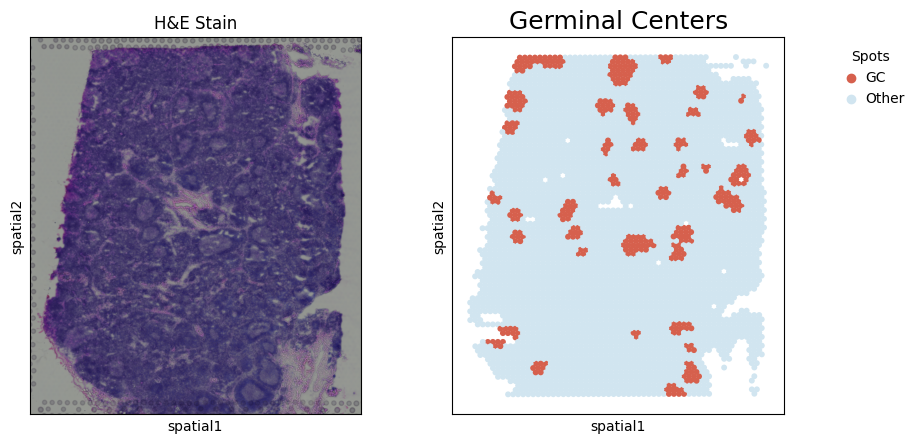

In [6]:
fig, axs = plt.subplots(1,2, figsize=(2*figsize, figsize), dpi=100)
sc.pl.spatial(adata_stan, ax=axs[0], show=False, title="H&E Stain")

sc.pl.spatial(adata_stan, color='germinal_center', size=1.8, alpha_img=0, 
              palette={"GC":'#d6604d', "Other":'#d1e5f0'},
              ax=axs[1], show=False, legend_fontsize=fontsize)
axs[1].set_title('Germinal Centers', fontsize=fontsize)
plt.legend(title="Spots", loc='upper right', bbox_to_anchor=(1.4, 1), columnspacing=0.5, handletextpad=0, frameon=False)

## Visualizing the cross validation performance

STAN performs better than Ridge.

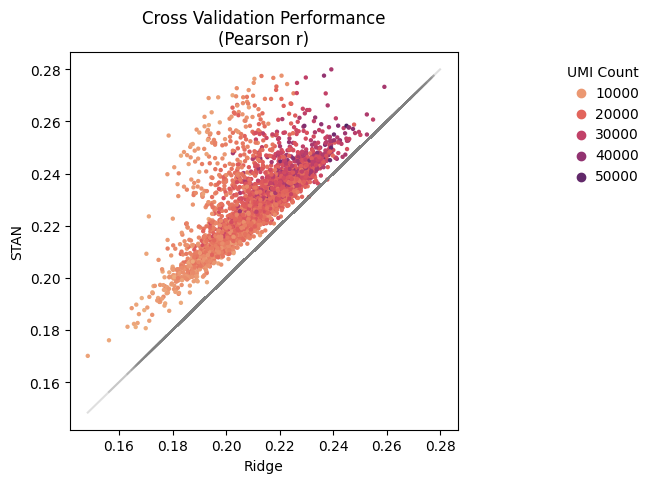

In [7]:
auxpl.plot_validation(adata_stan)

In [8]:
wilcoxon(adata_stan.obs["pred_cor_stan"], adata_stan.obs["pred_cor_ridge"], 
         zero_method='wilcox', correction=False, alternative='greater')

WilcoxonResult(statistic=7958053.0, pvalue=0.0)

The improvement benefit from spatial and morphological information is inversely correlated with the total unique molecular identifier (UMI) count per spot.

In [9]:
pearsonr(adata_stan.obs["pred_cor_stan"]-adata_stan.obs["pred_cor_ridge"],
         adata_stan.obs["n_counts"])

PearsonRResult(statistic=-0.20969451040886106, pvalue=7.014944770886749e-41)

## Visualizing TFa in spatial coordinates

We rank TFs for germinal centers and nongerminal centers.

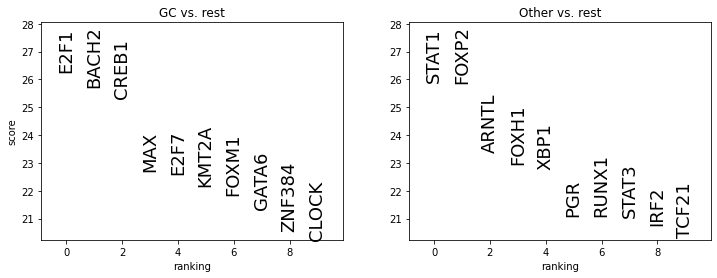

In [10]:
adata_tfa.obs['germinal_center'] = adata_tfa.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_tfa, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_tfa, fontsize=fontsize, n_genes=10)

We rank genes for germinal centers and nongerminal centers.

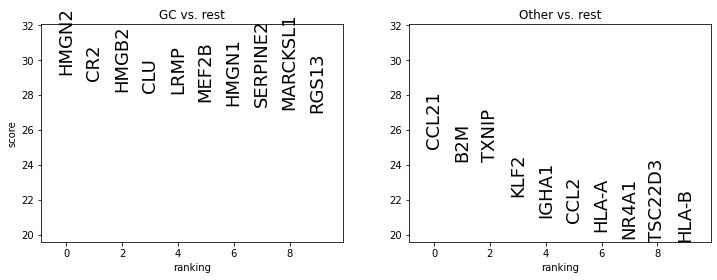

In [11]:
adata_raw.obs['germinal_center'] = adata_raw.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_raw, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_raw, fontsize=fontsize, n_genes=10)

Find the edges of the germinal centers.

In [12]:
points, edges = auxln.find_edges(adata_raw)

We create spatial plots for inferred TF activity of the top 3 ranked TFs in the germinal centers.

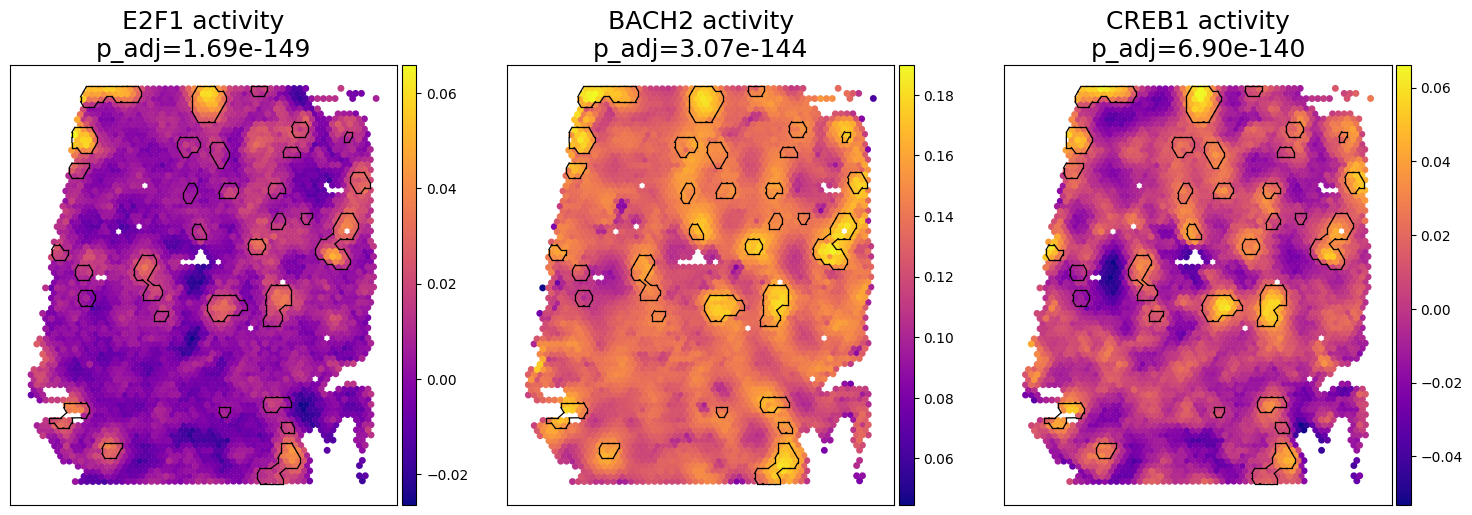

In [13]:
auxpl.plot_spatial_activity(adata_tfa, ['E2F1', 'BACH2', 'CREB1'], points, edges)

We create spatial plots for mRNA level of the top 3 ranked TFs in the germinal centers. We found fewer associations using TF mRNA expression levels directly.

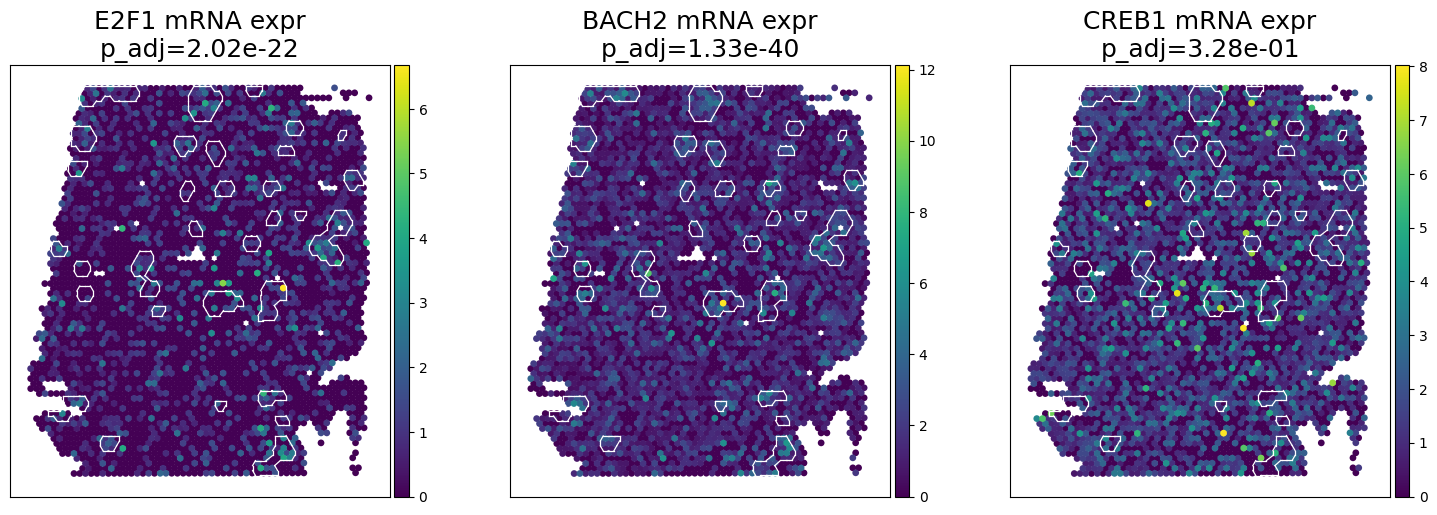

In [14]:
auxpl.plot_spatial_expression(adata_raw, ['E2F1', 'BACH2', 'CREB1'], points, edges)

## Embedding and Clustering

### Clustering based on TF Activity. 
More than half germinal centers are in Cluster 0.

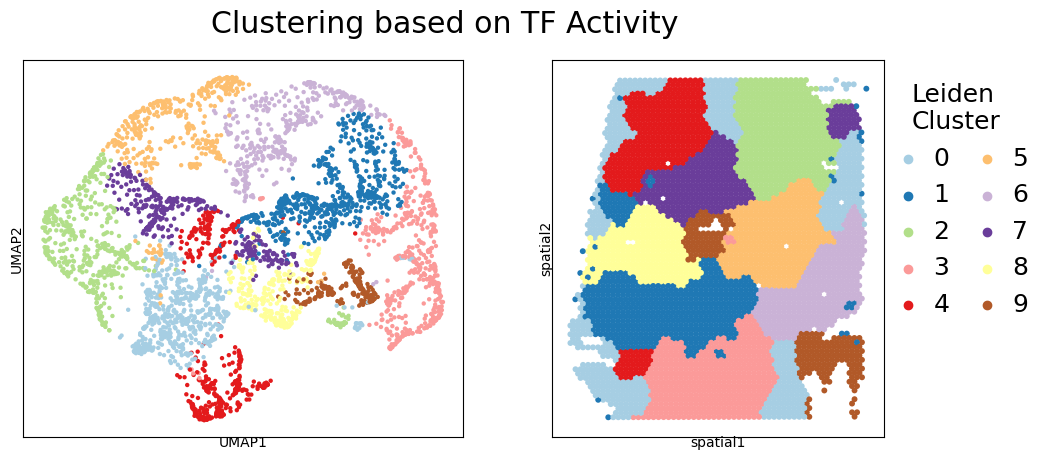

In [15]:
adata_tfa_scaled = adata_tfa.copy()
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.6)
auxpl.plot_umap(adata_tfa_scaled, palette='Paired')

In [16]:
pd.value_counts(adata_tfa_scaled.obs['leiden'][adata_tfa_scaled.obs['germinal_center']=='GC'])

leiden
0    203
5     64
8     39
2     31
7     16
4     10
3      3
6      2
1      0
9      0
Name: count, dtype: int64

### Clustering based on mRNA expression.
The spatial distribution based on mRNA expression is noisier and less precise.

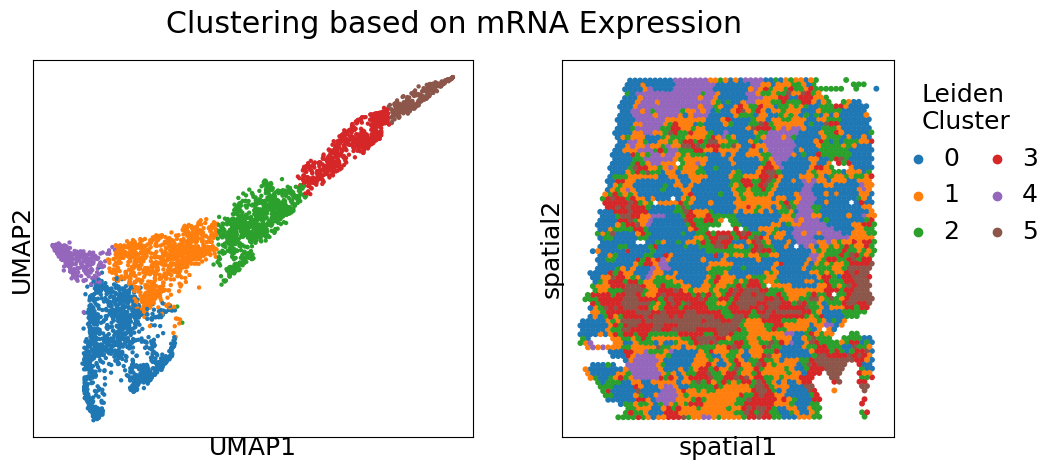

In [17]:
sc.pp.neighbors(adata_raw, use_rep='X', n_neighbors=100)
sc.tl.umap(adata_raw, min_dist=0.01)
sc.tl.leiden(adata_raw, resolution=0.42)
auxpl.plot_umap(adata_raw, palette=None, is_tf=False)

## Celltype Proportion and TF Activity

Merge some celltype groups with small proportion.

In [18]:
df_celltype = pd.DataFrame(0, index=adata_raw.obsm['celltype'].index, 
                          columns = ['B_Cycling', 'B_GC', 'B_IFN', 'B_activated', 'B_mem', 'B_naive', 'B_plasma', 'B_preGC', 
                                     'DC', 'Endo', 'FDC', 'ILC', 'Macrophages', 'Mast', 'Monocytes', 'NK', 'NKT', 
                                     'T_CD4+', 'T_CD8+', 'T_Treg', 'T_TIM3+', 'T_TfR', 'VSMC'])
for ct in ['B_Cycling', 'B_IFN', 'B_activated', 'B_mem', 'B_naive', 'B_plasma', 'B_preGC', 
           'Endo', 'FDC', 'ILC', 'Mast', 'Monocytes', 'NK', 'NKT', 'T_Treg', 'T_TIM3+', 'T_TfR', 'VSMC']:
    df_celltype[ct] = adata_raw.obsm['celltype'][ct]

for ct in ['B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB']:
    df_celltype['B_GC'] += adata_raw.obsm['celltype'][ct]

for ct in ['DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC']:
    df_celltype['DC'] += adata_raw.obsm['celltype'][ct]

for ct in ['Macrophages_M1', 'Macrophages_M2']:
    df_celltype['Macrophages'] += adata_raw.obsm['celltype'][ct]

for ct in ['T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive']:
    df_celltype['T_CD4+'] += adata_raw.obsm['celltype'][ct]
    
for ct in ['T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive']:
    df_celltype['T_CD8+'] += adata_raw.obsm['celltype'][ct]

adata_raw.obsm['celltype_major'] = df_celltype
adata_stan.obsm['celltype_major'] = df_celltype
adata_tfa.obsm['celltype_major'] = df_celltype  

### Correlating celltype proportion with TF activity and mRNA expression.

In [19]:
mat_cor_tfa, mat_cor_rna = auxpl.make_cor_dataframe(adata_raw, adata_tfa, celltype_label='celltype_major')

In [20]:
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(1,3, figsize=(figsize*3,figsize), dpi=100)
    sc.pl.spatial(sq.pl.extract(adata_tfa, "celltype_major"),
                  color=ct, alpha_img=0, ax=axs[0], show=False, cmap="rocket", size=1.8,
                  legend_fontsize=fontsize)
    sc.pl.spatial(adata_tfa, color=tf, alpha_img=0, ax=axs[1],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_raw, color=tf, alpha_img=0, ax=axs[2],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)

    axs[0].set_title(ct+'\n', fontsize=fontsize)
    axs[1].set_title(tf+' activity\npearson=%.4f'% mat_cor_tfa.loc[tf, ct], fontsize=fontsize)
    axs[2].set_title(tf+" mRNA expr\npearson=%.4f"% mat_cor_rna.loc[tf, ct], fontsize=fontsize)
    for i in range(3):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    plt.tight_layout(pad=0.6)

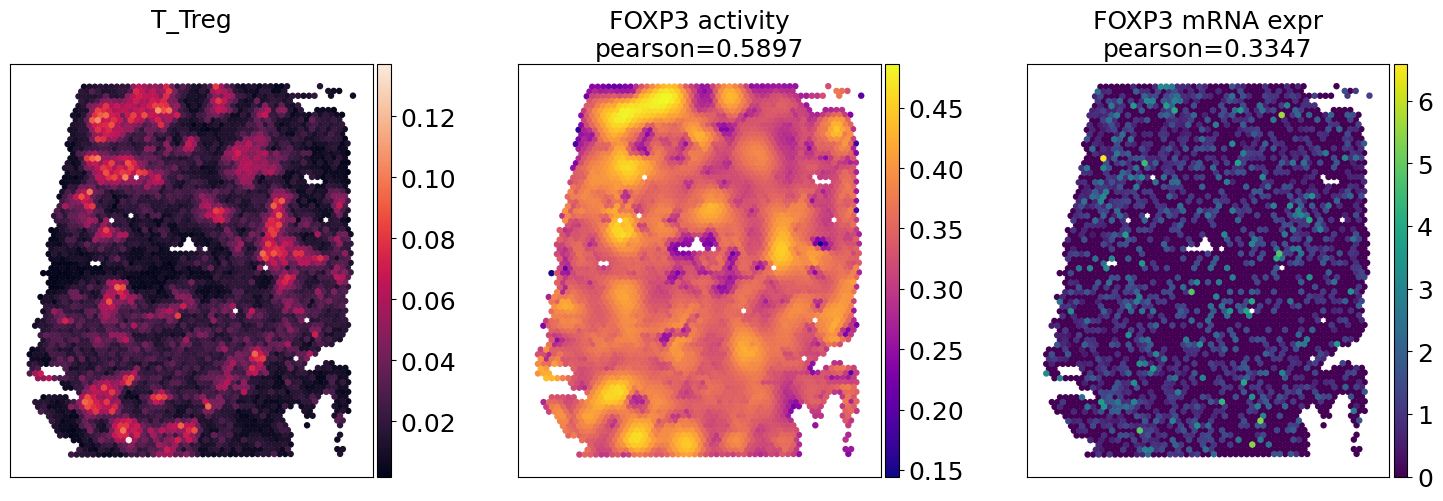

In [21]:
ct = "T_Treg"
tf = "FOXP3"
plot_spatial_ct_tf(ct, tf)

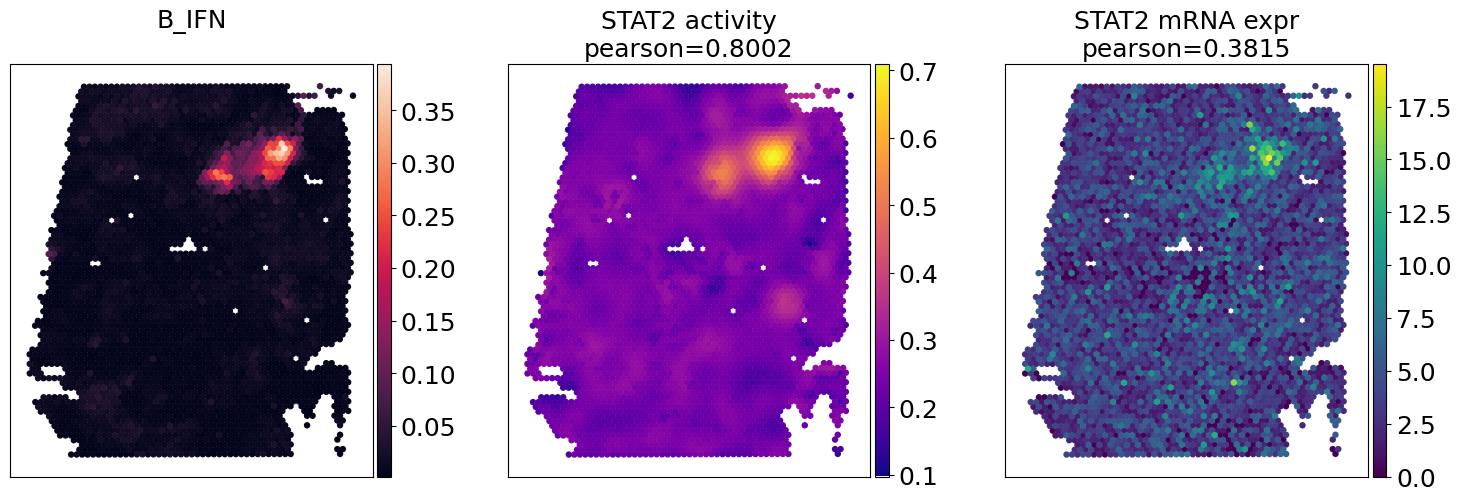

In [22]:
ct = "B_IFN"
tf = "STAT2"
plot_spatial_ct_tf(ct, tf)

### Compute celltype-specific TF activity score.

In [26]:
df_ct_tf = auxpl.make_ct_tf_dataframe(adata_tfa, celltype_label='celltype_major')

Select TFs and celltypes for visualization.

In [27]:
df_filtered = df_ct_tf.query("negative_log_p_adj>2").query('coef>4').query("r_squared>0.4")
tf_list = df_filtered['tf'].unique()
ct_list = df_filtered['ct'].unique()
print(tf_list)
print(ct_list)

['BACH2' 'BCL11A' 'CDX2' 'CREB1' 'E2F1' 'E2F7' 'EBF1' 'ETS1' 'ETV6'
 'FOXM1' 'FOXP2' 'FOXP3' 'GTF2B' 'IRF1' 'IRF2' 'KLF1' 'KMT2A' 'MAX' 'MYB'
 'NR5A2' 'PAX5' 'PBX1' 'PGR' 'POU2F2' 'PPARG' 'RFX3' 'SPIB' 'STAT1'
 'STAT2' 'STAT3' 'STAT4' 'STAT5B' 'TBX21' 'TCF21']
['B_Cycling' 'B_GC' 'T_TIM3+' 'B_preGC' 'B_activated' 'NK' 'T_CD8+' 'NKT'
 'VSMC' 'FDC' 'T_TfR' 'T_Treg' 'B_mem' 'B_plasma' 'Mast' 'Monocytes'
 'B_IFN' 'DC' 'ILC' 'Macrophages' 'T_CD4+']


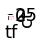

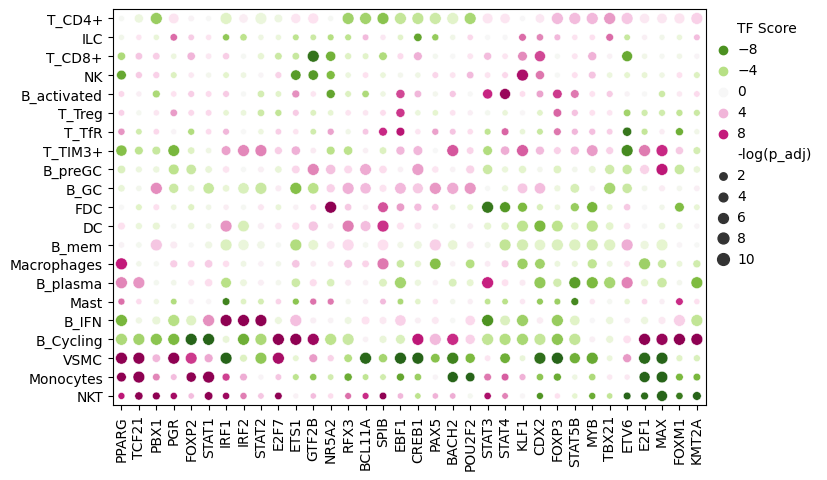

In [29]:
auxpl.plot_heatmap(df_ct_tf, tf_list, ct_list)